In [42]:
%reload_ext autoreload
%autoreload 2
import numpy as np, sys, os, pandas as pd,json, os
sys.path.insert(1, '../../')
from getting_data import read_conf

In [43]:
_, samples, __ = read_conf('.')

def print_metrics(key, arr):
    print(f'''[{key:11}] len: {len(arr):<6} sum: {round(np.sum(arr), 4):<10}, mean: {round(np.mean(arr), 4) if len(arr) > 1 else 0:<10}, std: {round(np.std(arr, ddof=1), 4) if len(arr) > 1 else 0:<10}''')

metrics = dict(
    title=[],
    abstract=[],
    venue=[],
    authors=[],
    year=[],
    n_citations=[],
)

for sample_key in samples.keys():
    sample_tasks = samples[sample_key]['anchor']['task']
    for task in sample_tasks:
        rg = task['range']
        m_file = os.path.join('scores', f"{sample_key}_anchor_metrics_{rg[0]}_{rg[1]}.npz")
        if os.path.exists(m_file):
            ld = np.load(m_file)
            title = ld['title']
            abstract = ld['abstract']
            venue = ld['venue']
            authors = ld['authors']
            year = ld['year']
            n_citations = ld['n_citations']
            idx = ld['idx']
            
            # print(idx)
            # print_metrics('title', title)
            # print_metrics('abstract', abstract)
            # print_metrics('venue', venue)
            # print_metrics('authors', authors)
            # print_metrics('year', year)
            # print_metrics('n_citations', n_citations)
            metrics['title'].extend(title)
            metrics['abstract'].extend(abstract)
            metrics['venue'].extend(venue)
            metrics['authors'].extend(authors)
            metrics['year'].extend(year)
            metrics['n_citations'].extend(n_citations)
            
            
for key in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
    if len(metrics[key]) < 92938:
        zeros = np.zeros([92938 - len(metrics[key])])
        metrics[key].extend(list(zeros))
    print_metrics(key, metrics[key])

[title      ] len: 92938  sum: 38371.9481, mean: 0.4129    , std: 0.2441    
[abstract   ] len: 92938  sum: 43815.043 , mean: 0.4714    , std: 0.2432    
[venue      ] len: 92938  sum: 1312.7621 , mean: 0.0141    , std: 0.0422    
[authors    ] len: 92938  sum: 408.0743  , mean: 0.0044    , std: 0.0173    
[year       ] len: 92938  sum: 3672.4624 , mean: 0.0395    , std: 0.0756    
[n_citations] len: 92938  sum: 1835.9845 , mean: 0.0198    , std: 0.0493    


In [44]:
from s2search_score_pdp import pdp_based_importance

std_fi = []
pdp_based_fi = []
sv_global_fi = []
all_data = []

for key in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
    feature_sv = metrics[key]
    
    if len(feature_sv) > 0:
        all_data.append(feature_sv)
        std_fi.append(np.std(feature_sv, ddof=1) \
            # + np.median(feature_sv)
        )
        # pdp_based_fi.append(pdp_based_importance(feature_sv))
        # sv_global_fi.append(np.mean(np.abs(feature_sv)))
    else:
        all_data.append([0])
        std_fi.append(0)
        pdp_based_fi.append(0)
        sv_global_fi.append(0)
        
# sv_global_fi

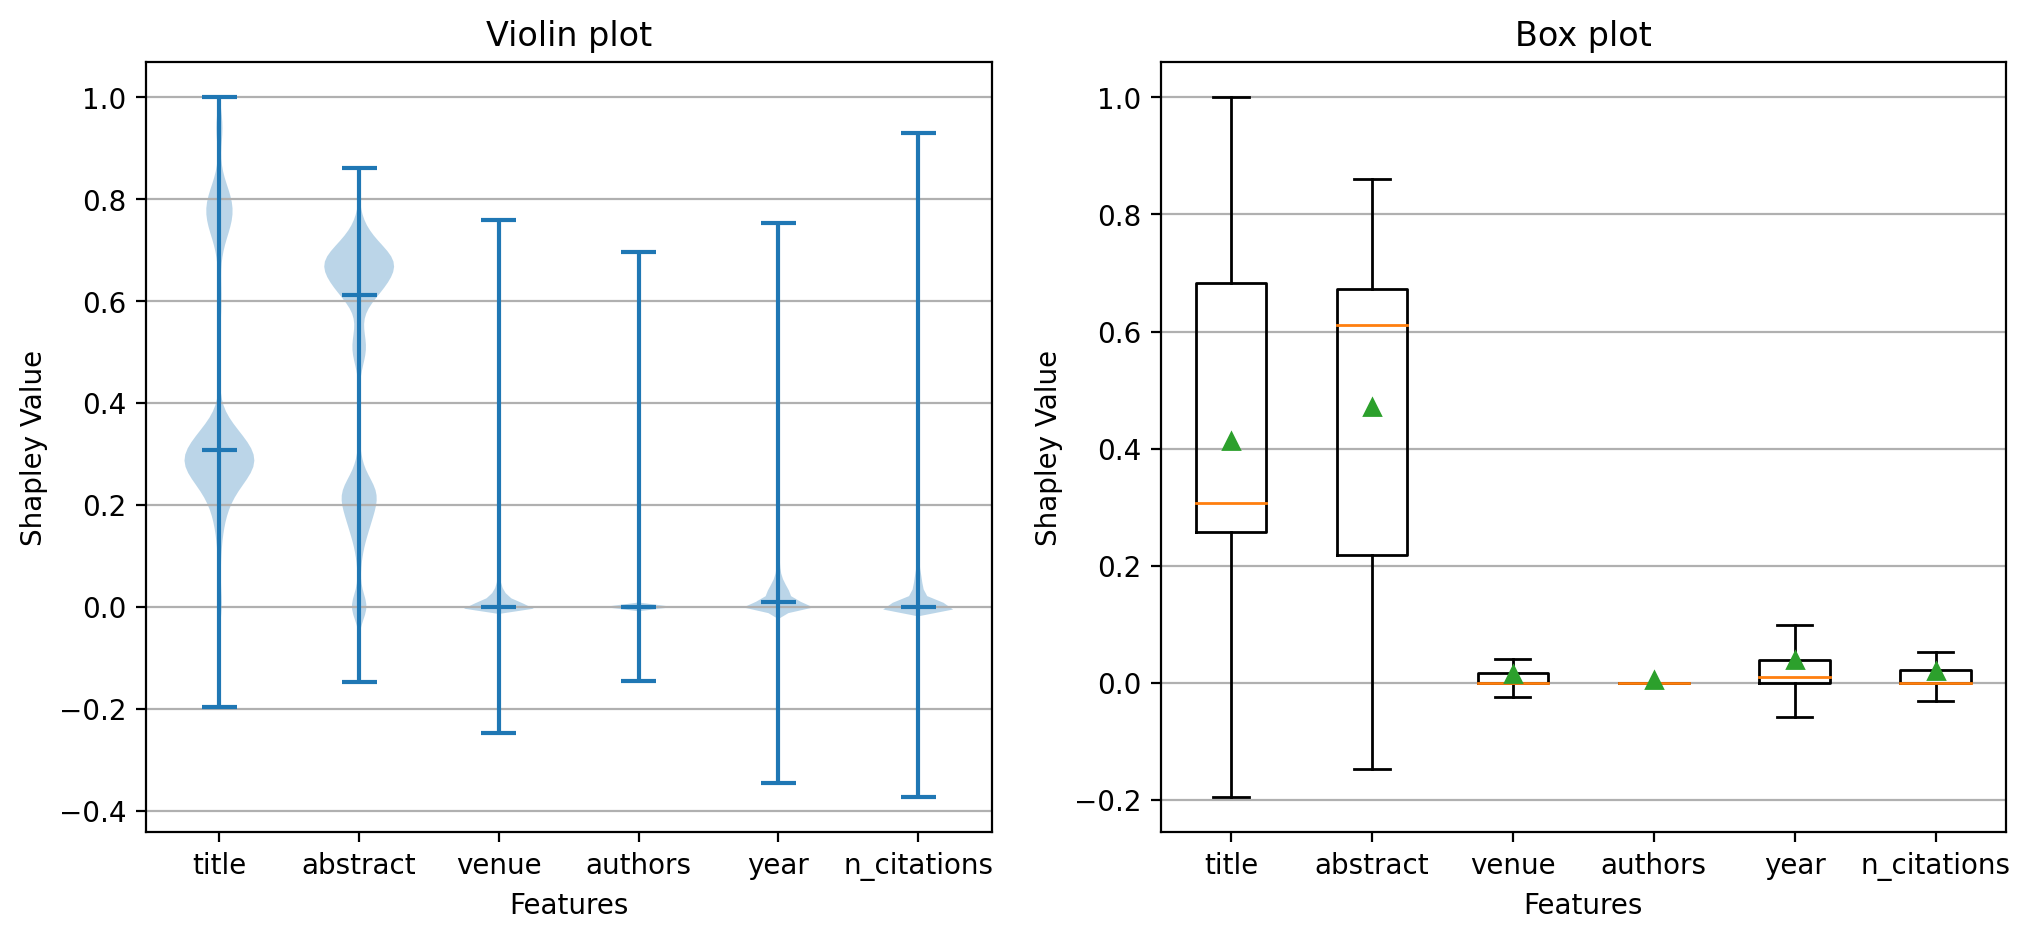

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=200)

# plot violin plot
axs[0].violinplot(all_data,
                  showmeans=False,
                  showmedians=True)
axs[0].set_title('Violin plot')

# plot box plot
axs[1].boxplot(all_data, 
               showfliers=False, 
               showmeans=True,
               )
axs[1].set_title('Box plot')

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))],
                  labels=['title', 'abstract', 'venue', 'authors', 'year', 'n_citations'])
    ax.set_xlabel('Features')
    ax.set_ylabel('Shapley Value')

plt.show()

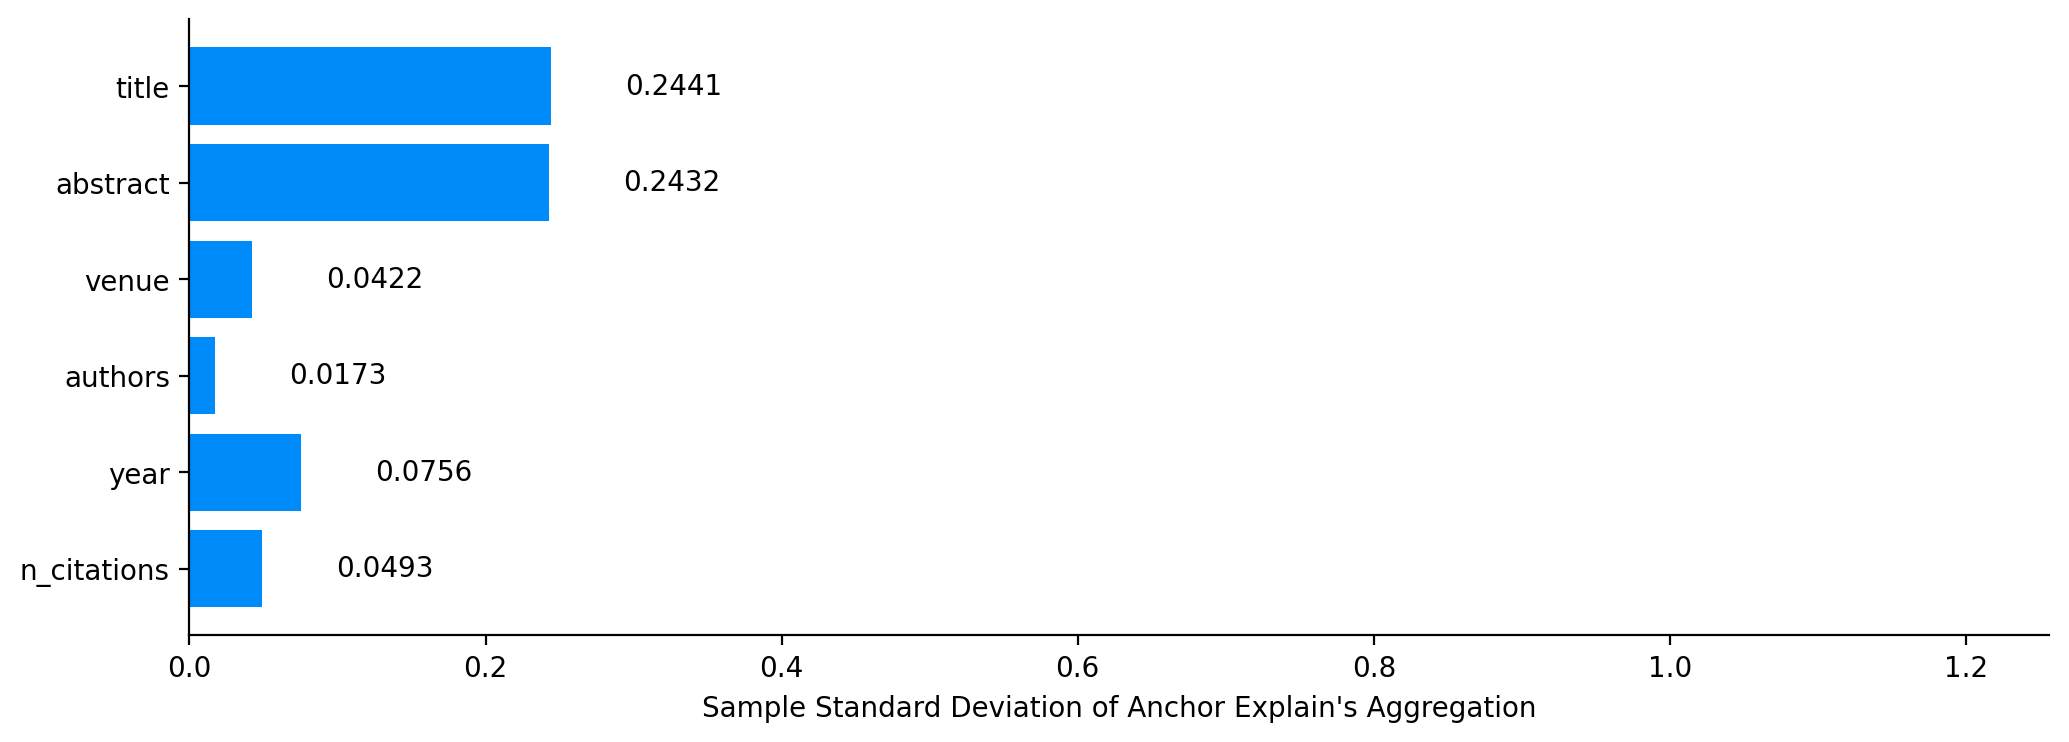

In [46]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

# Example data
feature_names = ('title', 'abstract', 'venue', 'authors', 'year', 'n_citations')
y_pos = np.arange(len(feature_names))
# error = np.random.rand(len(feature_names))

# ax.xaxis.grid(True)
ax.barh(y_pos, std_fi, align='center', color='#008bfb')
ax.set_yticks(y_pos, labels=feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sample Standard Deviation of Anchor Explain\'s Aggregation')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

_, xmax = plt.xlim()
plt.xlim(0, xmax + 1)
for i, v in enumerate(std_fi):
    margin = 0.05
    ax.text(v + margin if v > 0 else margin, i, str(round(v, 4)), color='black', ha='left', va='center')

plt.show()